In [15]:
import requests
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

def obtener_resultados_fda(api_key, drug_term):
    base_url = "https://api.fda.gov/drug/event.json"
    
    # Parámetros de búsqueda
    params = {
        'api_key': api_key,
        'search': f'"patient.drug.medicinalproduct.exact:""{drug_term}"',
        'count': "patient.reaction.reactionmeddrapt.exact"
        }

    headers = {
        'Content-Type': 'application/json',
    }

    try:
        # Realizar la llamada a la API
        response = requests.get(base_url,  params=params, headers=headers)
        response.raise_for_status()  # Verificar si hay errores en la respuesta HTTP

        # Convertir la respuesta a JSON
        data = response.json()

        # Verificar si 'results' está presente
        if 'results' in data:
            # Devolver el json resultante
            return data
        else:
            print(f"No se encontraron resultados para {drug_term}")
            return None
    
    except requests.exceptions.RequestException as e:
        print(f"Error en la llamada a la API para {drug_term}: {e}")

def obtener_resultados_fda_desde_lista(api_key, farmacos):
    
    df_resultados = pd.DataFrame(columns=['farmaco', 'term', 'count'])

    for farmaco in farmacos['Farmaco']:
        data = obtener_resultados_fda(api_key,farmaco)
        
        # Verificar si 'results' está presente en data
        if data is not None and 'results' in data:
            # Crear un DataFrame para los resultados del farmaco actual
            df_farmaco = pd.DataFrame(data['results'])
            df_farmaco['farmaco'] = farmaco
            
            # Concatenar al DataFrame principal
            df_resultados = pd.concat([df_resultados, df_farmaco], ignore_index=True)
        
        # Añadir un tiempo de espera de 1 segundo
        time.sleep(1)

    return df_resultados

In [ ]:
# Reemplaza 'tu_token_aqui' con tu token real
token_api = 'pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH'
drug_term = 'ipilimumab'

response= obtener_resultados_fda(token_api, drug_term)


In [3]:
with open('output.json', 'w', encoding='utf-8') as f:
            json.dump(response, f, ensure_ascii=False, indent=2)

In [ ]:
token_api = 'pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH'
farmacos = pd.read_csv("farmacos.csv", header = None, names = ['Farmaco'])

In [19]:
resultados = obtener_resultados_fda_desde_lista(token_api, farmacos)
resultados

Error en la llamada a la API: 404 Client Error: Not Found for url: https://api.fda.gov/drug/event.json?api_key=pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH&search=%22patient.drug.medicinalproduct.exact%3A%22%22emtansine+trastuzumab%22&count=patient.reaction.reactionmeddrapt.exact
Error en la llamada a la API: 404 Client Error: Not Found for url: https://api.fda.gov/drug/event.json?api_key=pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH&search=%22patient.drug.medicinalproduct.exact%3A%22%22deruxtecan+trastuzumab%22&count=patient.reaction.reactionmeddrapt.exact


,farmaco,term,count
0,pembrolizumab,MALIGNANT NEOPLASM PROGRESSION,7917
1,pembrolizumab,DEATH,4111
2,pembrolizumab,DIARRHOEA,3462
3,pembrolizumab,FATIGUE,3389
4,pembrolizumab,OFF LABEL USE,3002
...,...,...,...
6195,sotorasib,LIVER FUNCTION TEST ABNORMAL,7
6196,sotorasib,METASTASES TO BONE,7
6197,sotorasib,MUSCLE SPASMS,7
6198,sotorasib,NEOPLASM MALIGNANT,7


In [20]:
#Salvar resultados de la búsqueda en pubmed en .csv
resultados.to_csv('resultados_faers.csv', index=False)

In [11]:
#Cargar datos de Faers 
results_df = pd.read_csv('../results/resultados_faers.csv')
results_df = results_df.fillna(0)

In [12]:
#Preprocesamieto del dataframe

# Utilizamos la función pivot_table (gestiona duplicados) para convertir el DataFrame largo a uno ancho
results_df_wide = results_df.pivot_table(index='farmaco', columns='term', values='count')

#Se elimina la etiqueta farmaco como nombre de columna
results_df_wide.columns.name = None

#Se resetea los indices para que Tipo de tumor y los nombres de los farmacos esten al mismo nivel
results_df_wide.reset_index(inplace=True)

#Se extraen los 25 farmacos con mayor número de resultados en la bibliografía. Independientemente del tipo de tumor 
top_farmacos = results_df_wide.drop(columns=['farmaco']).sum().sort_values(ascending=False).head(12)

#Filtra el dataframe para quedarte solo con la columna de tipo de tumor y los farmacos con más resultados
results_df_wide = results_df_wide[['farmaco'] + list(top_farmacos.index)]

#Define el tipo de tumor como los indices del dataframe
results_df_wide.set_index('farmaco', inplace=True)

# Suma el total de resultados de los 15 fármacos para cada tipo de tumor y crea una nueva columna llamada 'TotalResultados'
results_df_wide['TotalResultados'] = results_df_wide[list(top_farmacos.index)].sum(axis=1)

# Ordena el DataFrame por la nueva columna 'TotalResultados' en orden descendente
results_df_wide = results_df_wide.sort_values(by='TotalResultados', ascending=False).reset_index()
results_df_wide = results_df_wide[['farmaco'] + list(top_farmacos.index)]
results_df_wide.set_index('farmaco', inplace=True)

results_df = results_df_wide.fillna(0)
results_df

,DEATH,DIARRHOEA,OFF LABEL USE,FATIGUE,NAUSEA,VOMITING,MALIGNANT NEOPLASM PROGRESSION,PYREXIA,DYSPNOEA,NEUTROPENIA,ASTHENIA,DISEASE PROGRESSION
farmaco,,,,,,,,,,,,
sodium chloride,21163.0,8795.0,11703.0,9269.0,11438.0,10363.0,0.0,8754.0,10578.0,2339.0,6940.0,0.0
denosumab,18647.0,4416.0,35462.0,6479.0,4628.0,2244.0,1884.0,2118.0,3191.0,1385.0,3527.0,1156.0
bevacizumab,11827.0,6634.0,10033.0,5631.0,6119.0,4691.0,2329.0,3673.0,3252.0,3525.0,3256.0,6395.0
capecitabine,8679.0,13326.0,3243.0,6362.0,8241.0,6058.0,3384.0,2359.0,2552.0,2767.0,3189.0,5697.0
carboplatin,3833.0,5201.0,5968.0,4005.0,6181.0,4653.0,4826.0,4083.0,5016.0,6012.0,3070.0,4714.0
...,...,...,...,...,...,...,...,...,...,...,...,...
sotorasib,209.0,207.0,123.0,67.0,72.0,34.0,12.0,20.0,34.0,0.0,27.0,293.0
plerixafor,50.0,97.0,65.0,39.0,80.0,49.0,11.0,85.0,35.0,43.0,22.0,20.0
paclitaxel albumin,39.0,34.0,39.0,19.0,39.0,23.0,61.0,46.0,16.0,30.0,19.0,17.0


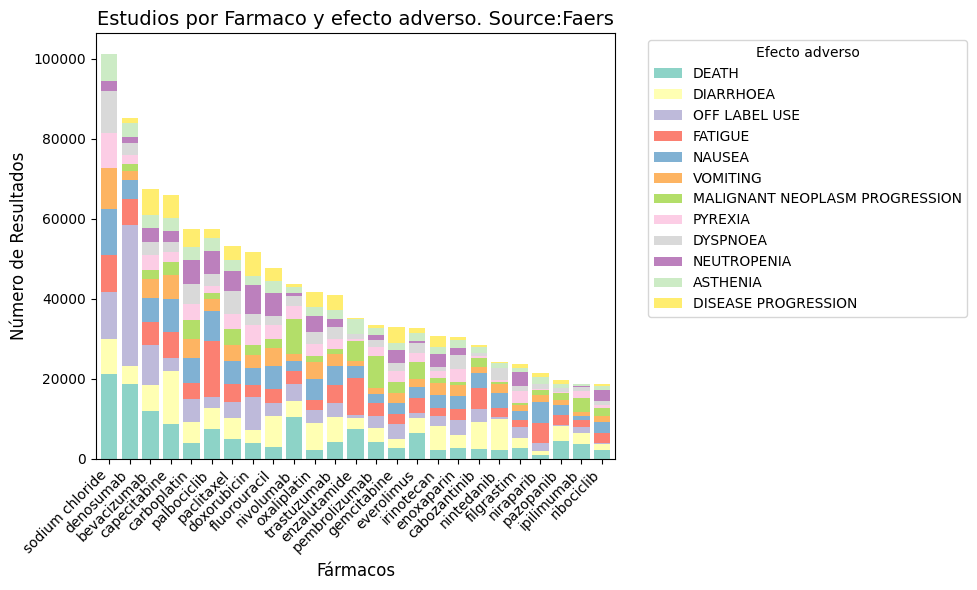

In [18]:
# Visualizar los resultados de cada farmaco en función del tipo de tumor

# Configura la paleta de colores única para cada fármaco con Seaborn
colors = sns.color_palette("Set3", n_colors=len(top_farmacos))

# Creamos un gráfico de barras apiladas
ax = results_df_wide.head(25).plot(kind='bar', stacked=True, figsize=(10, 6), color = colors, width=0.8)

# Añadimos etiquetas y título
ax.set_xlabel('Fármacos', fontsize=12)
ax.set_ylabel('Número de Resultados', fontsize=12)
ax.set_title('Estudios por Farmaco y efecto adverso. Source:Faers', fontsize=14)
ax.legend(title='Efecto adverso', bbox_to_anchor=(1.05, 1), loc='upper left')  # Colocar la leyenda a la derecha
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()